In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.signal import lfilter

In [2]:
"""
    Define simulation related parameters here
"""
# Mass of the sample
mass = 0.5
# Molar mass of the sample,SrTi0.5Mn0.5O3
molar_mass = (87.62 + 47.867*0.5 + 54.938*0.5 + 16*3)
# number of moles of sample
n = mass/molar_mass
# Ideal gas constant, unit J/mol*K
R = 8.31446261815324
# molar volume of gas, unit L/mol
v_molar = 22.4 
# flowrate, unit ml/min 
flowrate = 1000 
# Time interval chosen for calculation, unit s
t_interval = 0.01
# Temperature change rate, for this simulation, cooling and ramping are both 400 C/min
temp_rate = 400

In [3]:
def FindMolarFlowRate(P, V, T):
    # P in atm, V in mL/min, T in C
    R = 0.082057366080960 * 1000  # mL * atm / (K * mol)
    molarFlowRate = (P * V) / (R * (T + 273.15))  # From PV = nRT, ideal gas law
    return molarFlowRate

In [4]:
"""
    Funtions used to describe entropy and enthalpy of reduction in relation with non-stoichiometry
    entropy: J/mol*K
    enthalpy: J/mol
"""
def f_entropy(delta):
    result = -16*np.log(delta) + (-185)*delta**2 + 47*delta + 90
    return result

def f_enthalpy(delta):
    result = 276*delta + 196.1
    return result

In [5]:
"""
    Function used to calculate the equilibrium oxygen partial pressure 
    for a sample with known delta at temperature T
    Unit: atm
"""
def find_eq_pO2(delta, T):
    result = math.exp(2*(-f_enthalpy(delta)*1000 + T*f_entropy(delta)) / (R*T))
    return result

In [6]:
"""
    The function can be used to find delta 
        at equilibrium conditon under oxygen partial pressure pO2 and temperature T
    It can be used to check if the simulation arrives at a reasonable non-stoichiometry at certain point
"""
def find_delta(T, pO2, min_delta = 0.0001, max_delta = 0.2449):
    min_pO2 = find_eq_pO2(max_delta, T)
    eq_pO2 = find_eq_pO2(min_delta, T)
    if pO2 >= eq_pO2:
        return min_delta
    else:
        if pO2 < min_pO2:
            print('Sample completely reduced')
            return max_delta
        else:
            test_delta = (min_delta + max_delta) / 2
            eq_pO2 = find_eq_pO2(test_delta, T)
            while abs(math.log10(eq_pO2) - math.log10(pO2)) > 0.005:
                if eq_pO2 > pO2:
                    min_delta = test_delta
                    test_delta = (min_delta + max_delta) / 2
                    eq_pO2 = find_eq_pO2(test_delta, T)
                else:
                    max_delta = test_delta
                    test_delta = (min_delta + max_delta) / 2
                    eq_pO2 = find_eq_pO2(test_delta, T)
        return test_delta
temp_vals = range(300, 1500)

In [7]:
"""
    The first redution cycle, starts at T = 25 C, 
    ramps at ramp_rate to 1350 C, stays at 1350 C for 30 min,
    cools at cool_rate until it reaches final_temp (Tws)
    
    The function returns a list containing time stamp and corresponding temperature profile
"""

def initial_red_cycle_temp_profile(final_temp, ramp_rate = temp_rate, cool_rate = -temp_rate, t_interval = 0.01):
    time = []
    profile = []
    T = 25
    t = 0
    time.append(t)
    profile.append(T)
    while T < 1350:
        T += (ramp_rate)*t_interval
        t += t_interval
        profile.append(T)
        time.append(t)
    i = 0
    while i < 30:
        i += t_interval
        t += t_interval
        profile.append(T)
        time.append(t)
    while T > final_temp:
        T += (cool_rate)*t_interval
        t += t_interval
        profile.append(T)
        time.append(t)
    return [time, profile]

In [8]:
"""
    Function used to calculate the reduction "rate"
    pO2_in: gas inlet oxygen partial pressure
    p_tot: total pressure, usually 1 atm
"""
def calc_red_ddelta(pO2_in, p_tot, T, delta):
    pO2_eq = find_eq_pO2(delta, T + 273.15)
    F = FindMolarFlowRate(p_tot, 1000, 25)
    result = 2*F/n*(pO2_eq - pO2_in)/(p_tot - pO2_eq)
    return result

In [9]:
"""
    Simulation data of the initial reduction cycle
"""
T_low = 1150
def initial_red_cycle():
    red_timeline = initial_red_cycle_temp_profile(T_low)[0]
    red_temp_profile = initial_red_cycle_temp_profile(T_low)[1]
    T_initial = red_temp_profile[0]
    delta = 0.0036
    d_delta = calc_red_ddelta(1e-5, 1, T_initial, delta)
    red_Vdt = max(22.4 * 1000 / (2*molar_mass) * d_delta, 0)
    O2_rate_profile = [red_Vdt]
    O2_prod = [0]
    red_delta_profile = [delta]
    rate_profile = [d_delta]
    for i in range(len(red_timeline) - 1):
        new_delta = rate_profile[i]*t_interval + red_delta_profile[i]
        new_O2_prod = O2_rate_profile[i]*t_interval + O2_prod[i]
        O2_prod.append(new_O2_prod)
        red_delta_profile.append(new_delta)
        new_rate = calc_red_ddelta(1e-5, 1, red_temp_profile[i + 1], new_delta)
        new_red_Vdt = max(22.4 * 1000 / (2*molar_mass)*new_rate, 0)
        rate_profile.append(new_rate)
        O2_rate_profile.append(new_red_Vdt)
    return [red_timeline, red_temp_profile, red_delta_profile, rate_profile,
            O2_rate_profile, O2_prod]

In [10]:
"""
    calc_Keq returns the equilibrium coefficient K of water thermolysis reaction at temperature T
        using free energy data in the JANAF database
"""
import thermochem
from thermochem.janaf import *
db   = Janafdb()
H2O  = db.getphasedata(formula = 'H2O', phase = 'g')
H2   = db.getphasedata(formula = 'H2')
O2   = db.getphasedata(formula = 'O2')
CO   = db.getphasedata(formula = 'CO')
CO2  = db.getphasedata(formula = 'CO2')
R    = 8.314
F    = 96485

def calc_Keq(T):
    dG = H2O.DeltaG(T) - H2.DeltaG(T) - 0.5*O2.DeltaG(T)
    return np.exp(dG/R/T)

# Calculation the Vapor Pressure above water at T according to Wexler's Eqn.
# returns pressure value in unit of Pascal
def Pvapr_H2O(T):
    coef_g = [-2.8365744e3, -6.028076559e3, 1.954263612e1, -2.73780188e-2,
              1.6261698e-5, 7.0229056e-10, -1.8680009e-13]
    return math.exp(sum([pow(T, i - 2) * coef_g[i] for i in range(7)]) + 2.7150305 * math.log(T))


In [11]:
"""
    Function that describes the temperature profile of the oxidation cycle
        Oxidation cycle is an isothermal hold at iso_temp for 60 min
"""
def ox_cycle_temp_profile(iso_temp, t_interval = 0.01):
    t = 0
    time = [t]
    profile = [iso_temp]
    while t < 60:
        t += t_interval
        time.append(t)
        profile.append(iso_temp)
    return [time, profile]

In [12]:
"""
    Funtion to calculate the oxdation rate, the partial pressure of H2O in the inlet gas is 0.4 atm
"""
def calc_ox_ddelta(p_tot, T, delta, xH2O = 0.4):
    Keq = calc_Keq(T+273.15)
    F = FindMolarFlowRate(p_tot, 300, 25)
    pO2_eq = find_eq_pO2(delta, T + 273.15)
    ddelta = (F/n)*((2*pO2_eq**(3/2) + 2*pO2_eq*Keq - xH2O*Keq*(p_tot-pO2_eq))
                    /((pO2_eq**(1/2) + Keq) * (p_tot - pO2_eq)))
    return ddelta

In [13]:
"""
    Function that return all simulated result from an oxidation cycle
"""
def ox_cycle(prev_cycle):
    ox_timeline = ox_cycle_temp_profile(T_low)[0]
    ox_temp_profile = ox_cycle_temp_profile(T_low)[1]
    delta = prev_cycle[2][-1]
    T_cur = ox_temp_profile[0]
    d_delta = calc_ox_ddelta(1, T_cur, delta)
    if d_delta > 0:
        d_delta = 0
    ox_Vdt = -22.4 * 1000 / molar_mass * d_delta
    H2_rate_profile = [ox_Vdt]
    H2_prod = [0]
    ox_delta_profile = [delta]
    rate_profile = [d_delta]
    for i in range(len(ox_timeline) - 1):
        new_delta = rate_profile[i]*t_interval + ox_delta_profile[i]
        new_H2_prod = H2_rate_profile[i]*t_interval + H2_prod[i]
        H2_prod.append(new_H2_prod)
        ox_delta_profile.append(new_delta)
        new_rate = calc_ox_ddelta(1, ox_temp_profile[i + 1], new_delta)
        if new_rate > 0:
            new_rate = 0
        new_ox_Vdt = -22.4 * 1000 / molar_mass * new_rate
        rate_profile.append(new_rate)
        H2_rate_profile.append(new_ox_Vdt)
    return [ox_timeline, ox_temp_profile, ox_delta_profile, rate_profile,
            H2_rate_profile, H2_prod]

In [15]:
def red_cycle_temp_profile(initial_temp, final_temp, ramp_rate = temp_rate, cool_rate = -temp_rate, t_interval = 0.01):
    time = []
    profile = []
    T = initial_temp
    t = 0
    time.append(t)
    profile.append(T)
    while T < 1350:
        T += (ramp_rate)*t_interval
        t += t_interval
        profile.append(T)
        time.append(t)
    i = 0
    while i < 30:
        i += t_interval
        t += t_interval
        profile.append(T)
        time.append(t)
    while T > final_temp:
        T += (cool_rate)*t_interval
        t += t_interval
        profile.append(T)
        time.append(t)
    return [time, profile]

In [16]:
def red_cycle(prev_cycle):
    delta = prev_cycle[2][-1]
    T_initial = prev_cycle[1][-1]
    red_timeline = red_cycle_temp_profile(T_initial, T_low)[0]
    red_temp_profile = red_cycle_temp_profile(T_initial, T_low)[1]
    d_delta = calc_red_ddelta(1e-5, 1, T_initial, delta)
    red_Vdt = max(22.4 * 1000 / (2*molar_mass) * d_delta, 0)
    O2_rate_profile = [red_Vdt]
    O2_prod = [0]
    red_delta_profile = [delta]
    rate_profile = [d_delta]
    for i in range(len(red_timeline) - 1):
        new_delta = rate_profile[i]*t_interval + red_delta_profile[i]
        new_O2_prod = O2_rate_profile[i]*t_interval + O2_prod[i]
        O2_prod.append(new_O2_prod)
        red_delta_profile.append(new_delta)
        new_rate = calc_red_ddelta(1e-5, 1, red_temp_profile[i + 1], new_delta)
        new_red_Vdt = max(22.4 * 1000 / (2*molar_mass)*new_rate, 0)
        rate_profile.append(new_rate)
        O2_rate_profile.append(new_red_Vdt)
    return [red_timeline, red_temp_profile, red_delta_profile, rate_profile,
            O2_rate_profile, O2_prod]

In [17]:
def multi_cycle(num_cycle):
    init_red_cycle = initial_red_cycle()
    cur_red_cycle = init_red_cycle
    red_cycles = [cur_red_cycle]
    ox_cycle_1 = ox_cycle(cur_red_cycle)
    cur_ox_cycle = ox_cycle_1
    ox_cycles = [cur_ox_cycle]
    i = 0
    while i < num_cycle - 1:
        cur_red_cycle = red_cycle(cur_ox_cycle)
        red_cycles.append(cur_red_cycle)
        cur_ox_cycle = ox_cycle(cur_red_cycle)
        ox_cycles.append(cur_ox_cycle)
        i += 1
    return [red_cycles, ox_cycles]

In [18]:
complete_profile = multi_cycle(10)

In [19]:
red_cycles = complete_profile[0]
ox_cycles = complete_profile[1]

In [20]:
t = 0
complete_timeline = []
complete_H2_rate_profile = []
complete_O2_rate_profile = []
complete_ox_delta = []
H2_prod_percycle = []
O2_prod_percycle = []
for i in range(len(ox_cycles)):
    red_cycle = red_cycles[i]
    ox_cycle = ox_cycles[i]
    for j in range(len(red_cycle[0])):
        complete_timeline.append(t + red_cycle[0][j])
        complete_O2_rate_profile.append(red_cycle[4][j])
        complete_H2_rate_profile.append(0)
    t = t + red_cycle[0][-1]
    for j in range(len(ox_cycle[0])):
        complete_timeline.append(t + ox_cycle[0][j])
        complete_H2_rate_profile.append(ox_cycle[4][j])
        complete_O2_rate_profile.append(0)
    t = t + ox_cycle[0][-1]
    H2_prod_percycle.append(ox_cycle[5][-1])
    O2_prod_percycle.append(red_cycle[5][-1])

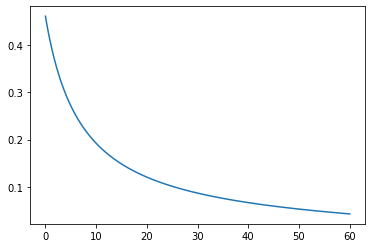

In [21]:
plt.plot(ox_cycles[0][0], ox_cycles[0][4])

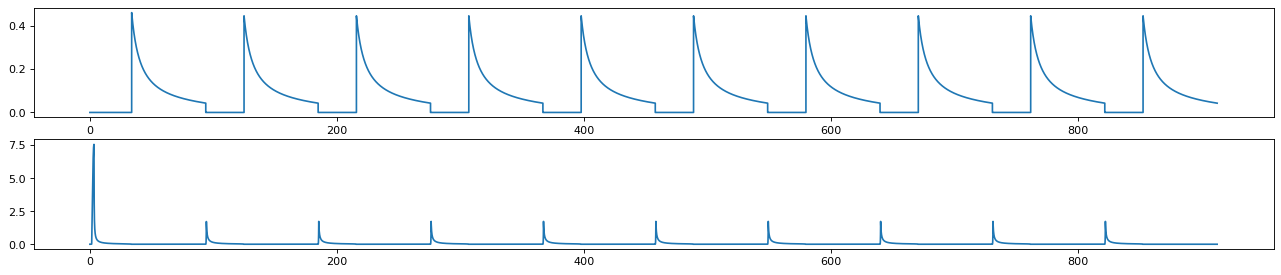

In [22]:
plt.figure(figsize=(20, 4), dpi=80)
plt.subplot(2, 1, 1)
plt.plot(complete_timeline, complete_H2_rate_profile)
plt.subplot(2, 1, 2)
plt.plot(complete_timeline, complete_O2_rate_profile)

Text(0, 0.5, 'Cumulative $H_{2}$ production (mL/g)')

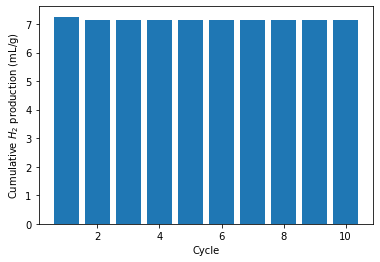

In [23]:
plt.bar(range(1, 11), H2_prod_percycle)
plt.xlabel('Cycle')
plt.ylabel('Cumulative $H_{2}$ production (mL/g)' )

In [24]:
d = {'Cycles': range(1, 11), 'H2 production (mL/g)': H2_prod_percycle,
         'O2 production (mL/g)': O2_prod_percycle}

In [25]:
print(d['H2 production (mL/g)'][9])
print(d['O2 production (mL/g)'][9])

7.156185538128359
3.584020578397703


<Figure size 2304x1296 with 0 Axes>

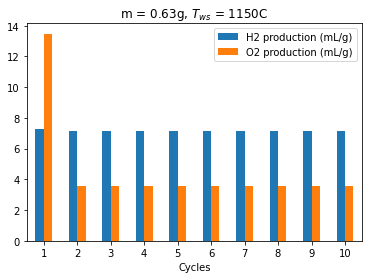

In [26]:
plt.figure(figsize=(32, 18))
len(H2_prod_percycle)
df = pd.DataFrame(data = d)
ax = df.plot(x="Cycles", y=["H2 production (mL/g)", "O2 production (mL/g)"], 
             kind="bar", rot=0, title='m = 0.63g, $T_{ws}$ = 1150C')

In [ ]:
#df.to_csv('STM55_0.5g_1150C.csv')

In [27]:
t = 0
complete_timeline = []
complete_H2_rate_profile = []
complete_O2_rate_profile = []
complete_temp_profile = []
complete_delta = []
H2_prod_percycle = []
O2_prod_percycle = []
for i in range(3):
    red_cycle = red_cycles[i]
    ox_cycle = ox_cycles[i]
    for j in range(len(red_cycle[0])):
        complete_temp_profile.append(red_cycle[1][j])
        complete_timeline.append(t + red_cycle[0][j])
        complete_O2_rate_profile.append(red_cycle[4][j])
        complete_H2_rate_profile.append(0)
        complete_delta.append(red_cycle[2][j])
    t = t + red_cycle[0][-1]
    for j in range(len(ox_cycle[0])):
        complete_timeline.append(t + ox_cycle[0][j])
        complete_temp_profile.append(ox_cycle[1][j])
        complete_H2_rate_profile.append(ox_cycle[4][j])
        complete_O2_rate_profile.append(0)
        complete_delta.append(ox_cycle[2][j])
    t = t + ox_cycle[0][-1]
    H2_prod_percycle.append(ox_cycle[5][-1])
    O2_prod_percycle.append(red_cycle[5][-1])

<Figure size 1600x320 with 0 Axes>

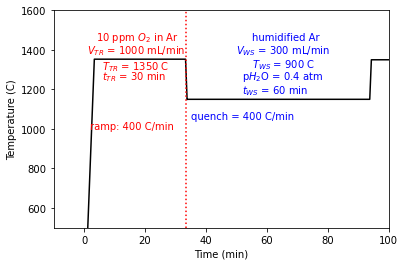

In [28]:
plt.figure(figsize=(20, 4), dpi=80)
fig, ax = plt.subplots()
ax.axis([-10, 100, 500, 1600])
plt.plot(complete_timeline, complete_temp_profile, color = 'black')
#plt.axvline(x=(1350-590)/400, color = 'r', linestyle = ':')
plt.axvline(x=(1350-590)/400 + (1350-900)/400+30 + 0.5, color = 'r', linestyle = ':')
ax.text((1350-590)/400 + 2, 1450, '10 ppm $O_{2}$ in Ar', color = 'r')
ax.text((1350-590)/400 - 1, 1380, '$V_{TR}$ = 1000 mL/min', color = 'r')
ax.text((1350-590)/400 + 4, 1300, '$T_{TR}$ = 1350 C', color = 'r')
ax.text((1350-590)/400 + 4, 1250, '$t_{TR}$ = 30 min', color = 'r')
ax.text(55, 1200 + 250, 'humidified Ar', color = 'b')
ax.text(50, 1130 + 250, '$V_{WS}$ = 300 mL/min', color = 'b')
ax.text(55, 1060 + 250, '$T_{WS}$ = 900 C', color = 'b')
ax.text(52, 1000 + 250, 'p$H_{2}$O = 0.4 atm', color = 'b')
ax.text(52, 930 + 250, '$t_{WS}$ = 60 min', color = 'b')
ax.text((1350-590)/800 + 1, 1000, 'ramp: 400 C/min', color = 'r')
ax.text(35, 800+250, 'quench = 400 C/min', color = 'b')
plt.xlabel('Time (min)')
plt.ylabel('Temperature (C)')
plt.savefig('Test.jpeg', dpi = 1000)
plt.show()

Text(0.5, 0, 'Time (min)')

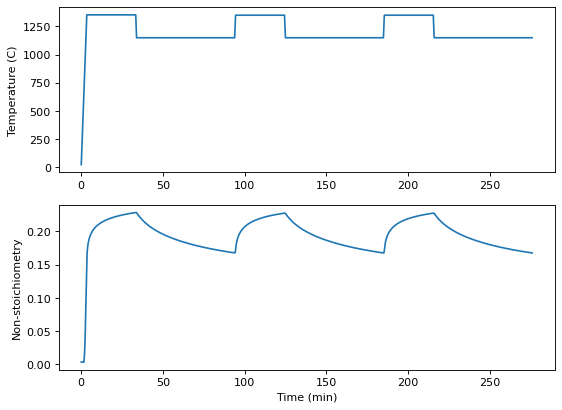

In [29]:
plt.figure(figsize=(8, 6), dpi=80)
plt.subplot(2, 1, 1)
plt.plot(complete_timeline, complete_temp_profile)
plt.ylabel('Temperature (C)')
plt.subplot(2, 1, 2)
plt.plot(complete_timeline, complete_delta)
plt.ylabel('Non-stoichiometry')
plt.xlabel('Time (min)')


Text(0.5, 0, 'Time (min)')

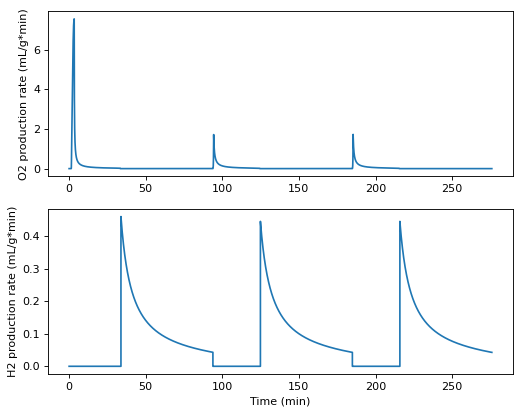

In [30]:
plt.figure(figsize=(7.5, 6), dpi=80)
plt.subplot(2, 1, 1)
plt.plot(complete_timeline, complete_O2_rate_profile)
plt.ylabel('O2 production rate (mL/g*min)')
plt.subplot(2, 1, 2)
plt.plot(complete_timeline, complete_H2_rate_profile)
plt.ylabel('H2 production rate (mL/g*min)')
plt.xlabel('Time (min)')